In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from IPython.display import clear_output
import os
from services import MySQLService
from helpers.file import save_file, parse_df_to_csv
from helpers.elo import update_elo, reset_season_elo
from helpers.feature_engineer import (
    current_streak,
    get_team_per_mean,
    get_team_defensive_rating_game,
    get_team_offensive_rating_game,
    get_wl_pct,
)
from helpers.stats import get_team_stats, get_team_previous_games

In [2]:
first_season = 2012
last_season = 2023

mysql = MySQLService()

totals_n_last_games = 10
n_last_games = 10
n_last_specific_games = 5

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
season_games = mysql.execute_query(f"SELECT * from `nba-data`.games WHERE season >= {first_season} and season <= {last_season} ORDER BY date ASC;")
season_games_plyrs = mysql.execute_query(f"SELECT g.id as game_id, g.date, g.season, g.is_playoff, g.winner, g.home_id, g.away_id, pg.team_id, pg.player_id, pg.minutes, pg.pts, pg.fgm, pg.fga, pg.fg_pct, pg.fg3m, pg.fg3a, pg.fg3_pct, pg.ftm, pg.fta, pg.ft_pct, pg.oreb, pg.dreb, pg.reb, pg.ast, pg.stl, pg.blk, pg.tov, pg.pf, pg.plus_minus FROM player_games AS pg LEFT JOIN games as g on pg.game_id = g.id WHERE g.season >= {first_season} and g.season <= {last_season} ORDER BY g.date ASC")
teams = mysql.execute_query(f"SELECT * FROM teams")

C:\Users\caiog\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\caiog\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\caiog\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
season_games['home_off_rtg'] = season_games.apply(lambda row: get_team_offensive_rating_game(row, 'H'), axis = 1)
season_games['home_def_rtg'] = season_games.apply(lambda row: get_team_defensive_rating_game(row, 'H'), axis = 1)

season_games['away_off_rtg'] = season_games.apply(lambda row: get_team_offensive_rating_game(row, 'A'), axis = 1)
season_games['away_def_rtg'] = season_games.apply(lambda row: get_team_defensive_rating_game(row, 'A'), axis = 1)

In [5]:
display(season_games.head(2))
display(season_games_plyrs.head(2))
display(teams.head(2))

,id,date,season,is_playoff,winner,home_id,home_team,home_pts,home_fgm,home_fga,...,away_stl,away_blk,away_tov,away_pf,home_odds,away_odds,home_off_rtg,home_def_rtg,away_off_rtg,away_def_rtg
0,21200001,2012-10-30,2012,0,H,1610612739,Cleveland Cavaliers,94,36,79,...,11,10,13,19,1.41,2.93,103.524229,92.511013,90.322581,101.075269
1,21200002,2012-10-30,2012,0,H,1610612748,Miami Heat,120,43,79,...,4,2,16,23,1.35,3.26,126.582278,112.869198,112.394958,126.050420


,game_id,date,season,is_playoff,winner,home_id,away_id,team_id,player_id,minutes,...,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,plus_minus
0,21200003,2012-10-30,2012,0,A,1610612747,1610612742,1610612742,203109,19,...,0.0,0,3,3,2,1,0,0,1,2
1,21200002,2012-10-30,2012,0,H,1610612748,1610612738,1610612738,203096,8,...,0.0,0,1,1,0,0,0,0,1,-3


,id,name,abbreviation
0,1610612737,Atlanta Hawks,ATL
1,1610612738,Boston Celtics,BOS


In [6]:
teams_elo_dict = dict()

for i, team in teams.iterrows():
    teams_elo_dict[team['id']] = 1500

In [7]:
def get_match_info(
    game_info, stats_team_a, stats_team_b, winner, team_a_pts, team_b_pts
):
    return game_info + stats_team_a + stats_team_b + [winner, team_a_pts, team_b_pts]


def get_game_data(
    season_games, season_games_plyrs, game, team_id, opp_id, teams_per, scenario
):
    response = get_team_previous_games(
        season_games, team_id, game["date"], game["season"]
    )
    if not response:
        return None, None

    (
        _,
        _,
        previous_games,
        previous_season_games,
        home_previous_season_games,
        away_previous_season_games,
    ) = response

    if len(previous_season_games.index) < 10:
        return None, None

    last_n_games = previous_season_games.iloc[-n_last_games:, :]

    # Get last game ELO
    elo = teams_elo_dict[team_id]

    # Last n games pct
    pct_last_n_games = get_wl_pct(last_n_games)[0]

    # Getting Previous A x B Matchups
    last_matchups = previous_games[previous_games["opp_id"] == opp_id].iloc[-10:, :]

    # Getting player information
    teams_per[team_id] = get_team_per_mean(
        team_id, game["id"], game["date"], game["season"], season_games_plyrs
    )

    # Season Win Percentage
    season_pct = get_wl_pct(previous_season_games)[0]

    # Last n/2 games pct and Season H/A Win Percentage
    if scenario == "H":
        ha_pct_last_n_games = get_wl_pct(
            home_previous_season_games.iloc[-n_last_specific_games:, :]
        )[0]
        ha_pct = get_wl_pct(home_previous_season_games)[0]
    else:
        ha_pct_last_n_games = get_wl_pct(
            away_previous_season_games.iloc[-n_last_specific_games:, :]
        )[0]
        ha_pct = get_wl_pct(away_previous_season_games)[0]

    # Matchup Win Percentage
    matchup_pct = get_wl_pct(last_matchups)[0]

    # Calculating Current Streak
    streak = current_streak(previous_season_games)

    stats_team = get_team_stats(
        last_n_games,
        season_pct,
        teams_per[team_id],
        elo,
        matchup_pct,
        ha_pct,
        streak,
        pct_last_n_games,
        ha_pct_last_n_games,
    )

    return stats_team, elo

In [8]:
print("Creating CSV file of all games...")

teams_per = dict()

matches_organized = []
matches_organized_playoffs = []
season = ""

season_games_iterr = season_games.loc[season_games["season"] >= first_season]
season_games_iterr.reset_index(drop=True, inplace=True)

for i, g in season_games_iterr.iterrows():
    clear_output(wait=True)
    print(f"{i}/{len(season_games_iterr.index)}")

    if season != g["season"]:
        reset_season_elo(teams_elo_dict)

        if g["season"] == 2023:
            save_file("elo", teams_elo_dict, "elo_dict")

    season = g["season"]

    if season < first_season:
        continue

    is_playoffs = int(g["is_playoff"])

    team_a_id = g["home_id"]
    team_b_id = g["away_id"]

    team_a_abbv = teams.loc[teams["id"] == team_a_id].iloc[0]["abbreviation"]
    team_b_abbv = teams.loc[teams["id"] == team_b_id].iloc[0]["abbreviation"]

    winner = g["winner"]

    # Update ELO after stats computed
    team_a_pts = g["home_pts"]
    team_b_pts = g["away_pts"]

    team_a_odds, team_b_odds = g["home_odds"], g["away_odds"]

    if not team_a_odds or not team_b_odds:
        continue

    stats_team_a, elo_a = get_game_data(
        season_games, season_games_plyrs, g, team_a_id, team_b_id, teams_per, "H"
    )
    if not stats_team_a:
        continue

    stats_team_b, elo_b = get_game_data(
        season_games, season_games_plyrs, g, team_b_id, team_a_id, teams_per, "A"
    )
    if not stats_team_b:
        continue

    update_elo(
        winner,
        elo_a,
        elo_b,
        teams_elo_dict,
        team_a_id,
        team_b_id,
        team_a_pts,
        team_b_pts,
    )

    match_info = get_match_info(
        [season, g["date"], team_a_abbv, team_b_abbv, team_a_odds, team_b_odds],
        stats_team_a,
        stats_team_b,
        winner,
        team_a_pts,
        team_b_pts,
    )
    if is_playoffs:
        matches_organized_playoffs.append(match_info)
    else:
        matches_organized.append(match_info)

14766/14767


In [9]:
print(
    "Total matches: {}\nTotal playoffs matches: {}".format(
        len(matches_organized), len(matches_organized_playoffs)
    )
)

Total matches: 11968
Total playoffs matches: 918


In [10]:
columns = [
    "SEASON_ID",
    "GAME_DATE",
    "TEAM_A",
    "TEAM_B",
    "ODDS_A",
    "ODDS_B",
    "PTS_A",
    "PTS_CON_A",
    "FG_PCT_A",
    "FG3_PCT_A",
    "FT_PCT_A",
    "REB_A",
    "TOV_A",
    "SEASON_A_PCT",
    "PER_A",
    "ELO_A",
    "MATCHUP_A_PCT",
    "HA_A_PCT",
    "STREAK_A",
    "LAST_GAMES_PCT_A",
    "HA_LAST_GAMES_PCT_A",
    "OFF_RTG_A",
    "DEF_RTG_A",
    "PTS_B",
    "PTS_CON_B",
    "FG_PCT_B",
    "FG3_PCT_B",
    "FT_PCT_B",
    "REB_B",
    "TOV_B",
    "SEASON_B_PCT",
    "PER_B",
    "ELO_B",
    "MATCHUP_B_PCT",
    "HA_B_PCT",
    "STREAK_B",
    "LAST_GAMES_PCT_B",
    "HA_LAST_GAMES_PCT_B",
    "OFF_RTG_B",
    "DEF_RTG_B",
    "WINNER",
    "GAME_PTS_A",
    "GAME_PTS_B",
]

final_df = parse_df_to_csv(
    matches_organized, columns, "../data", "{}-{}.csv".format(first_season, last_season)
)

parse_df_to_csv(
    matches_organized_playoffs,
    columns,
    "../data/playoffs",
    "{}-{}.csv".format(first_season, last_season),
)

display(final_df)

,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,MATCHUP_B_PCT,HA_B_PCT,STREAK_B,LAST_GAMES_PCT_B,HA_LAST_GAMES_PCT_B,OFF_RTG_B,DEF_RTG_B,WINNER,GAME_PTS_A,GAME_PTS_B
0,2012,2012-11-17,PHX,MIA,3.2,1.36,99.3,105.0,0.4307,0.3241,...,1.0,0.500000,1,0.7,0.6,111.655660,107.418542,A,88,97
1,2012,2012-11-18,DET,BOS,2.46,1.56,93.0,99.8,0.4378,0.3553,...,0.0,0.600000,1,0.6,0.6,105.807366,104.982441,H,103,83
2,2012,2012-11-19,DAL,GSW,1.16,5.34,100.9,100.1,0.4627,0.3893,...,0.0,0.500000,-1,0.5,0.4,100.099647,102.401857,A,101,105
3,2012,2012-11-19,UTA,HOU,1.33,3.37,96.2,97.8,0.4370,0.3231,...,0.0,0.400000,-2,0.4,0.4,102.150776,102.700599,H,102,91
4,2012,2012-11-20,PHI,TOR,1.45,2.77,88.9,90.1,0.4109,0.4000,...,0.0,0.200000,1,0.3,0.2,100.874199,104.481087,H,106,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11963,2023,2024-01-21,PHX,IND,1.38,3.11,117.8,113.3,0.5047,0.3771,...,0.4,0.523810,-1,0.6,0.4,117.560759,115.483577,H,117,110
11964,2023,2024-01-21,LAL,POR,1.17,5.25,114.1,120.4,0.4953,0.3582,...,0.4,0.227273,2,0.3,0.2,99.323529,118.428491,H,134,110
11965,2023,2024-01-22,DET,MIL,1.38,3.11,119.3,128.9,0.4906,0.3957,...,0.9,0.526316,1,0.5,0.4,119.085533,121.521600,A,113,122
11966,2023,2024-01-22,ORL,CLE,2.12,1.75,107.8,110.3,0.4531,0.3583,...,0.7,0.588235,7,0.8,0.6,117.749453,103.199365,A,99,126


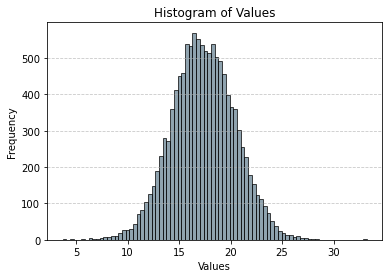

In [11]:
import matplotlib.pyplot as plt

plt.hist(final_df['PER_B'], bins='auto', alpha=0.7, color='#607c8e', edgecolor='black')

# Customize the plot
plt.title('Histogram of Values')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()